In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GaussianDropout, GaussianNoise
from keras.layers import GRU, Bidirectional, TimeDistributed
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 6
W2V_SIZE = 200

SEQUENCE_LENGTH = 200

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [4]:
df_train = pd.read_csv("yelp2015/train.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = pd.read_csv("yelp2015/test.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
def preprocess(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
      tokens.append(token)
    return " ".join(tokens)

In [6]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

Wall time: 21.4 s


In [7]:
decode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

Wall time: 395 ms


In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\covin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
%%time
documents = [_text.split() for _text in df_train.text]

Wall time: 10.5 s


In [11]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [12]:
w2v_model.build_vocab(documents)

2020-04-28 17:43:12,953 : INFO : collecting all words and their counts
2020-04-28 17:43:12,954 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-28 17:43:13,215 : INFO : PROGRESS: at sentence #10000, processed 1301608 words, keeping 73325 word types
2020-04-28 17:43:13,468 : INFO : PROGRESS: at sentence #20000, processed 2581717 words, keeping 119474 word types
2020-04-28 17:43:13,735 : INFO : PROGRESS: at sentence #30000, processed 3869673 words, keeping 157572 word types
2020-04-28 17:43:13,998 : INFO : PROGRESS: at sentence #40000, processed 5133261 words, keeping 188307 word types
2020-04-28 17:43:14,271 : INFO : PROGRESS: at sentence #50000, processed 6392410 words, keeping 217321 word types
2020-04-28 17:43:14,519 : INFO : PROGRESS: at sentence #60000, processed 7635534 words, keeping 242870 word types
2020-04-28 17:43:14,790 : INFO : PROGRESS: at sentence #70000, processed 8936557 words, keeping 272165 word types
2020-04-28 17:43:15,072 : INFO : 

2020-04-28 17:43:34,464 : INFO : downsampling leaves estimated 64954863 word corpus (76.0% of prior 85422479)
2020-04-28 17:43:35,008 : INFO : estimated required memory for 152070 words and 200 dimensions: 319347000 bytes
2020-04-28 17:43:35,009 : INFO : resetting layer weights


In [13]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 152070


In [14]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-04-28 17:44:04,937 : INFO : training model with 8 workers on 152070 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-04-28 17:44:05,957 : INFO : EPOCH 1 - PROGRESS: at 1.85% examples, 1137022 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:44:06,959 : INFO : EPOCH 1 - PROGRESS: at 3.77% examples, 1184294 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:44:07,977 : INFO : EPOCH 1 - PROGRESS: at 5.75% examples, 1180936 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:44:08,990 : INFO : EPOCH 1 - PROGRESS: at 7.79% examples, 1193433 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:44:09,995 : INFO : EPOCH 1 - PROGRESS: at 9.75% examples, 1193105 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:44:11,008 : INFO : EPOCH 1 - PROGRESS: at 11.67% examples, 1197079 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:44:12,011 : INFO : EPOCH 1 - PROGRESS: at 13.70% examples, 1198143 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:44:13,031 : INFO : EPOCH 1 - PROGRE

2020-04-28 17:45:10,463 : INFO : EPOCH 2 - PROGRESS: at 20.58% examples, 1163927 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:45:11,464 : INFO : EPOCH 2 - PROGRESS: at 22.42% examples, 1168043 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:45:12,475 : INFO : EPOCH 2 - PROGRESS: at 24.22% examples, 1168229 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:45:13,483 : INFO : EPOCH 2 - PROGRESS: at 25.77% examples, 1168495 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:45:14,489 : INFO : EPOCH 2 - PROGRESS: at 27.35% examples, 1168937 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:45:15,501 : INFO : EPOCH 2 - PROGRESS: at 29.12% examples, 1170529 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:45:16,512 : INFO : EPOCH 2 - PROGRESS: at 30.94% examples, 1172277 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:45:17,517 : INFO : EPOCH 2 - PROGRESS: at 32.78% examples, 1171898 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:45:18,518 : INFO : EPOCH 2 - PROGRESS: at 34.53% examples, 1173169

2020-04-28 17:46:15,794 : INFO : EPOCH 3 - PROGRESS: at 37.83% examples, 1160736 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:46:16,802 : INFO : EPOCH 3 - PROGRESS: at 39.84% examples, 1163228 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:46:17,812 : INFO : EPOCH 3 - PROGRESS: at 41.69% examples, 1163934 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:46:18,828 : INFO : EPOCH 3 - PROGRESS: at 43.51% examples, 1163689 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:46:19,832 : INFO : EPOCH 3 - PROGRESS: at 45.33% examples, 1163464 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:46:20,848 : INFO : EPOCH 3 - PROGRESS: at 46.95% examples, 1158506 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:46:21,848 : INFO : EPOCH 3 - PROGRESS: at 48.72% examples, 1158596 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:46:22,855 : INFO : EPOCH 3 - PROGRESS: at 50.44% examples, 1158491 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:46:23,855 : INFO : EPOCH 3 - PROGRESS: at 52.37% examples, 1158534

2020-04-28 17:47:20,324 : INFO : EPOCH 4 - PROGRESS: at 53.80% examples, 1189270 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:47:21,328 : INFO : EPOCH 4 - PROGRESS: at 55.49% examples, 1187684 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:47:22,340 : INFO : EPOCH 4 - PROGRESS: at 57.31% examples, 1186388 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:47:23,340 : INFO : EPOCH 4 - PROGRESS: at 58.92% examples, 1184657 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:47:24,348 : INFO : EPOCH 4 - PROGRESS: at 60.70% examples, 1184151 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:47:25,353 : INFO : EPOCH 4 - PROGRESS: at 62.56% examples, 1184459 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:47:26,357 : INFO : EPOCH 4 - PROGRESS: at 64.43% examples, 1184757 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:47:27,368 : INFO : EPOCH 4 - PROGRESS: at 66.31% examples, 1184743 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:47:28,383 : INFO : EPOCH 4 - PROGRESS: at 68.20% examples, 1185693

2020-04-28 17:48:25,398 : INFO : EPOCH 5 - PROGRESS: at 71.27% examples, 1176929 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:48:26,402 : INFO : EPOCH 5 - PROGRESS: at 72.99% examples, 1175635 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:48:27,421 : INFO : EPOCH 5 - PROGRESS: at 74.80% examples, 1175140 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:48:28,425 : INFO : EPOCH 5 - PROGRESS: at 76.33% examples, 1172409 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:48:29,428 : INFO : EPOCH 5 - PROGRESS: at 78.10% examples, 1171775 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:48:30,438 : INFO : EPOCH 5 - PROGRESS: at 80.02% examples, 1172704 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:48:31,453 : INFO : EPOCH 5 - PROGRESS: at 81.90% examples, 1173198 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:48:32,454 : INFO : EPOCH 5 - PROGRESS: at 83.69% examples, 1172959 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:48:33,467 : INFO : EPOCH 5 - PROGRESS: at 85.49% examples, 1172575

2020-04-28 17:49:30,885 : INFO : EPOCH 6 - PROGRESS: at 89.55% examples, 1177574 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:49:31,894 : INFO : EPOCH 6 - PROGRESS: at 91.41% examples, 1177831 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:49:32,907 : INFO : EPOCH 6 - PROGRESS: at 93.25% examples, 1178437 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:49:33,916 : INFO : EPOCH 6 - PROGRESS: at 95.14% examples, 1178705 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:49:34,936 : INFO : EPOCH 6 - PROGRESS: at 96.99% examples, 1178491 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:49:35,940 : INFO : EPOCH 6 - PROGRESS: at 98.90% examples, 1179164 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:49:36,540 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-28 17:49:36,546 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-28 17:49:36,547 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-28 17:49:36,548 : INFO : work

2020-04-28 17:50:31,438 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-28 17:50:31,441 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-28 17:50:31,443 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-28 17:50:31,444 : INFO : EPOCH - 7 : training on 87161194 raw words (64954622 effective words) took 54.9s, 1183791 effective words/s
2020-04-28 17:50:32,454 : INFO : EPOCH 8 - PROGRESS: at 1.86% examples, 1151963 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:50:33,468 : INFO : EPOCH 8 - PROGRESS: at 3.75% examples, 1173505 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:50:34,481 : INFO : EPOCH 8 - PROGRESS: at 5.77% examples, 1183103 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:50:35,483 : INFO : EPOCH 8 - PROGRESS: at 7.56% examples, 1160035 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:50:36,484 : INFO : EPOCH 8 - PROGRESS: at 9.56% examples, 1170379 words/s, in_qsize 16, out_qsize 0
2020-04-28 17:50

2020-04-28 17:51:34,546 : INFO : EPOCH 9 - PROGRESS: at 13.46% examples, 1176243 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:51:35,564 : INFO : EPOCH 9 - PROGRESS: at 15.37% examples, 1172974 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:51:36,573 : INFO : EPOCH 9 - PROGRESS: at 17.22% examples, 1173308 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:51:37,593 : INFO : EPOCH 9 - PROGRESS: at 19.18% examples, 1175163 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:51:38,601 : INFO : EPOCH 9 - PROGRESS: at 20.92% examples, 1175560 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:51:39,602 : INFO : EPOCH 9 - PROGRESS: at 22.75% examples, 1176800 words/s, in_qsize 16, out_qsize 1
2020-04-28 17:51:40,614 : INFO : EPOCH 9 - PROGRESS: at 24.56% examples, 1177294 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:51:41,636 : INFO : EPOCH 9 - PROGRESS: at 26.11% examples, 1176714 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:51:42,651 : INFO : EPOCH 9 - PROGRESS: at 27.71% examples, 1177489

2020-04-28 17:52:39,371 : INFO : EPOCH 10 - PROGRESS: at 31.55% examples, 1192159 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:52:40,392 : INFO : EPOCH 10 - PROGRESS: at 33.36% examples, 1192040 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:52:41,397 : INFO : EPOCH 10 - PROGRESS: at 35.19% examples, 1192070 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:52:42,412 : INFO : EPOCH 10 - PROGRESS: at 37.02% examples, 1191925 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:52:43,424 : INFO : EPOCH 10 - PROGRESS: at 39.01% examples, 1191785 words/s, in_qsize 16, out_qsize 0
2020-04-28 17:52:44,431 : INFO : EPOCH 10 - PROGRESS: at 40.92% examples, 1191722 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:52:45,433 : INFO : EPOCH 10 - PROGRESS: at 42.75% examples, 1191915 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:52:46,440 : INFO : EPOCH 10 - PROGRESS: at 44.62% examples, 1190698 words/s, in_qsize 12, out_qsize 3
2020-04-28 17:52:47,445 : INFO : EPOCH 10 - PROGRESS: at 46.44% examples

2020-04-28 17:53:44,054 : INFO : EPOCH 11 - PROGRESS: at 49.35% examples, 1175532 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:53:45,055 : INFO : EPOCH 11 - PROGRESS: at 51.20% examples, 1175960 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:53:46,057 : INFO : EPOCH 11 - PROGRESS: at 53.09% examples, 1175459 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:53:47,066 : INFO : EPOCH 11 - PROGRESS: at 54.92% examples, 1176018 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:53:48,072 : INFO : EPOCH 11 - PROGRESS: at 56.78% examples, 1176746 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:53:49,092 : INFO : EPOCH 11 - PROGRESS: at 58.47% examples, 1176430 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:53:50,093 : INFO : EPOCH 11 - PROGRESS: at 60.31% examples, 1177080 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:53:51,110 : INFO : EPOCH 11 - PROGRESS: at 62.15% examples, 1177177 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:53:52,109 : INFO : EPOCH 11 - PROGRESS: at 64.02% examples

2020-04-28 17:54:49,341 : INFO : EPOCH 12 - PROGRESS: at 68.35% examples, 1186782 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:54:50,355 : INFO : EPOCH 12 - PROGRESS: at 70.09% examples, 1186221 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:54:51,365 : INFO : EPOCH 12 - PROGRESS: at 71.89% examples, 1186147 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:54:52,365 : INFO : EPOCH 12 - PROGRESS: at 73.74% examples, 1186531 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:54:53,367 : INFO : EPOCH 12 - PROGRESS: at 75.53% examples, 1186265 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:54:54,376 : INFO : EPOCH 12 - PROGRESS: at 77.32% examples, 1186422 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:54:55,387 : INFO : EPOCH 12 - PROGRESS: at 79.16% examples, 1186315 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:54:56,404 : INFO : EPOCH 12 - PROGRESS: at 81.04% examples, 1186427 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:54:57,408 : INFO : EPOCH 12 - PROGRESS: at 82.90% examples

2020-04-28 17:55:54,109 : INFO : EPOCH 13 - PROGRESS: at 86.60% examples, 1187224 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:55:55,110 : INFO : EPOCH 13 - PROGRESS: at 88.40% examples, 1187345 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:55:56,114 : INFO : EPOCH 13 - PROGRESS: at 90.19% examples, 1186913 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:55:57,120 : INFO : EPOCH 13 - PROGRESS: at 92.01% examples, 1187051 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:55:58,124 : INFO : EPOCH 13 - PROGRESS: at 93.86% examples, 1186705 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:55:59,131 : INFO : EPOCH 13 - PROGRESS: at 95.78% examples, 1187113 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:56:00,142 : INFO : EPOCH 13 - PROGRESS: at 97.63% examples, 1187256 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:56:01,144 : INFO : EPOCH 13 - PROGRESS: at 99.52% examples, 1187644 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:56:01,381 : INFO : worker thread finished; awaiting finish

2020-04-28 17:56:55,951 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-28 17:56:55,953 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-28 17:56:55,967 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-28 17:56:55,969 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-28 17:56:55,969 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-28 17:56:55,974 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-28 17:56:55,975 : INFO : EPOCH - 14 : training on 87161194 raw words (64952944 effective words) took 54.6s, 1190524 effective words/s
2020-04-28 17:56:56,997 : INFO : EPOCH 15 - PROGRESS: at 1.91% examples, 1167377 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:56:58,015 : INFO : EPOCH 15 - PROGRESS: at 3.81% examples, 1182464 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:56:59,026 : INFO : EPOCH 15 - PROGRESS: at 5.82% examples, 1188043 w

2020-04-28 17:57:55,883 : INFO : EPOCH 16 - PROGRESS: at 9.73% examples, 1192830 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:57:56,889 : INFO : EPOCH 16 - PROGRESS: at 11.59% examples, 1193427 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:57:57,900 : INFO : EPOCH 16 - PROGRESS: at 13.60% examples, 1192650 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:57:58,902 : INFO : EPOCH 16 - PROGRESS: at 15.56% examples, 1193249 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:57:59,907 : INFO : EPOCH 16 - PROGRESS: at 17.39% examples, 1190794 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:58:00,908 : INFO : EPOCH 16 - PROGRESS: at 19.27% examples, 1190289 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:58:01,910 : INFO : EPOCH 16 - PROGRESS: at 21.06% examples, 1191931 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:58:02,917 : INFO : EPOCH 16 - PROGRESS: at 22.90% examples, 1190816 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:58:03,927 : INFO : EPOCH 16 - PROGRESS: at 24.66% examples,

2020-04-28 17:59:00,704 : INFO : EPOCH 17 - PROGRESS: at 27.74% examples, 1185469 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:59:01,709 : INFO : EPOCH 17 - PROGRESS: at 29.48% examples, 1185629 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:59:02,717 : INFO : EPOCH 17 - PROGRESS: at 31.34% examples, 1186238 words/s, in_qsize 15, out_qsize 0
2020-04-28 17:59:03,721 : INFO : EPOCH 17 - PROGRESS: at 33.10% examples, 1185074 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:59:04,724 : INFO : EPOCH 17 - PROGRESS: at 34.91% examples, 1184901 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:59:05,724 : INFO : EPOCH 17 - PROGRESS: at 36.69% examples, 1185104 words/s, in_qsize 13, out_qsize 2
2020-04-28 17:59:06,736 : INFO : EPOCH 17 - PROGRESS: at 38.70% examples, 1186079 words/s, in_qsize 14, out_qsize 1
2020-04-28 17:59:07,755 : INFO : EPOCH 17 - PROGRESS: at 40.65% examples, 1186327 words/s, in_qsize 16, out_qsize 1
2020-04-28 17:59:08,755 : INFO : EPOCH 17 - PROGRESS: at 42.39% examples

2020-04-28 18:00:05,848 : INFO : EPOCH 18 - PROGRESS: at 45.90% examples, 1175515 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:00:06,853 : INFO : EPOCH 18 - PROGRESS: at 47.70% examples, 1176184 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:00:07,865 : INFO : EPOCH 18 - PROGRESS: at 49.47% examples, 1175883 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:00:08,875 : INFO : EPOCH 18 - PROGRESS: at 51.32% examples, 1175737 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:00:09,882 : INFO : EPOCH 18 - PROGRESS: at 53.21% examples, 1174979 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:00:10,894 : INFO : EPOCH 18 - PROGRESS: at 54.99% examples, 1174493 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:00:11,915 : INFO : EPOCH 18 - PROGRESS: at 56.84% examples, 1174563 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:00:12,919 : INFO : EPOCH 18 - PROGRESS: at 58.51% examples, 1174346 words/s, in_qsize 16, out_qsize 2
2020-04-28 18:00:13,920 : INFO : EPOCH 18 - PROGRESS: at 60.37% examples

2020-04-28 18:01:10,910 : INFO : EPOCH 19 - PROGRESS: at 64.54% examples, 1186912 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:01:11,915 : INFO : EPOCH 19 - PROGRESS: at 66.39% examples, 1186851 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:01:12,929 : INFO : EPOCH 19 - PROGRESS: at 68.26% examples, 1187363 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:01:13,937 : INFO : EPOCH 19 - PROGRESS: at 70.04% examples, 1187587 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:01:14,942 : INFO : EPOCH 19 - PROGRESS: at 71.80% examples, 1186991 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:01:15,945 : INFO : EPOCH 19 - PROGRESS: at 73.64% examples, 1186923 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:01:16,953 : INFO : EPOCH 19 - PROGRESS: at 75.46% examples, 1186983 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:01:17,960 : INFO : EPOCH 19 - PROGRESS: at 77.21% examples, 1186549 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:01:18,978 : INFO : EPOCH 19 - PROGRESS: at 79.05% examples

2020-04-28 18:02:15,766 : INFO : EPOCH 20 - PROGRESS: at 82.78% examples, 1186837 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:02:16,777 : INFO : EPOCH 20 - PROGRESS: at 84.62% examples, 1186392 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:02:17,789 : INFO : EPOCH 20 - PROGRESS: at 86.49% examples, 1186735 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:02:18,795 : INFO : EPOCH 20 - PROGRESS: at 88.28% examples, 1186723 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:02:19,808 : INFO : EPOCH 20 - PROGRESS: at 90.15% examples, 1186858 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:02:20,808 : INFO : EPOCH 20 - PROGRESS: at 91.95% examples, 1187123 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:02:21,809 : INFO : EPOCH 20 - PROGRESS: at 93.84% examples, 1187419 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:02:22,822 : INFO : EPOCH 20 - PROGRESS: at 95.73% examples, 1187102 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:02:23,827 : INFO : EPOCH 20 - PROGRESS: at 97.52% examples

2020-04-28 18:03:19,952 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-28 18:03:19,955 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-28 18:03:19,957 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-28 18:03:19,958 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-28 18:03:19,967 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-28 18:03:19,971 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-28 18:03:19,974 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-28 18:03:19,979 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-28 18:03:19,980 : INFO : EPOCH - 21 : training on 87161194 raw words (64953404 effective words) took 54.8s, 1185218 effective words/s
2020-04-28 18:03:20,993 : INFO : EPOCH 22 - PROGRESS: at 1.90% examples, 1169452 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:0

2020-04-28 18:04:17,839 : INFO : EPOCH 23 - PROGRESS: at 5.83% examples, 1190309 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:04:18,844 : INFO : EPOCH 23 - PROGRESS: at 7.80% examples, 1193817 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:04:19,853 : INFO : EPOCH 23 - PROGRESS: at 9.75% examples, 1189440 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:04:20,858 : INFO : EPOCH 23 - PROGRESS: at 11.63% examples, 1193036 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:04:21,874 : INFO : EPOCH 23 - PROGRESS: at 13.67% examples, 1192857 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:04:22,875 : INFO : EPOCH 23 - PROGRESS: at 15.63% examples, 1194297 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:04:23,890 : INFO : EPOCH 23 - PROGRESS: at 17.52% examples, 1194612 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:04:24,895 : INFO : EPOCH 23 - PROGRESS: at 19.42% examples, 1194614 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:04:25,917 : INFO : EPOCH 23 - PROGRESS: at 21.22% examples, 1

2020-04-28 18:05:22,683 : INFO : EPOCH 24 - PROGRESS: at 24.62% examples, 1187182 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:05:23,697 : INFO : EPOCH 24 - PROGRESS: at 25.99% examples, 1177115 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:05:24,707 : INFO : EPOCH 24 - PROGRESS: at 27.12% examples, 1157754 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:05:25,709 : INFO : EPOCH 24 - PROGRESS: at 28.68% examples, 1151305 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:05:26,720 : INFO : EPOCH 24 - PROGRESS: at 30.47% examples, 1153183 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:05:27,732 : INFO : EPOCH 24 - PROGRESS: at 32.24% examples, 1151781 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:05:28,737 : INFO : EPOCH 24 - PROGRESS: at 33.90% examples, 1149692 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:05:29,748 : INFO : EPOCH 24 - PROGRESS: at 35.56% examples, 1146003 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:05:30,750 : INFO : EPOCH 24 - PROGRESS: at 37.22% examples

2020-04-28 18:06:28,110 : INFO : EPOCH 25 - PROGRESS: at 38.08% examples, 1166478 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:06:29,123 : INFO : EPOCH 25 - PROGRESS: at 40.01% examples, 1167034 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:06:30,132 : INFO : EPOCH 25 - PROGRESS: at 41.85% examples, 1167920 words/s, in_qsize 12, out_qsize 3
2020-04-28 18:06:31,145 : INFO : EPOCH 25 - PROGRESS: at 43.76% examples, 1169213 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:06:32,149 : INFO : EPOCH 25 - PROGRESS: at 45.61% examples, 1169638 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:06:33,158 : INFO : EPOCH 25 - PROGRESS: at 47.42% examples, 1169811 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:06:34,171 : INFO : EPOCH 25 - PROGRESS: at 49.21% examples, 1170010 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:06:35,173 : INFO : EPOCH 25 - PROGRESS: at 50.96% examples, 1169247 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:06:36,182 : INFO : EPOCH 25 - PROGRESS: at 52.87% examples

2020-04-28 18:07:32,641 : INFO : EPOCH 26 - PROGRESS: at 51.20% examples, 1096997 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:07:33,657 : INFO : EPOCH 26 - PROGRESS: at 52.96% examples, 1095965 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:07:34,661 : INFO : EPOCH 26 - PROGRESS: at 54.62% examples, 1095342 words/s, in_qsize 16, out_qsize 0
2020-04-28 18:07:35,665 : INFO : EPOCH 26 - PROGRESS: at 56.22% examples, 1093906 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:07:36,665 : INFO : EPOCH 26 - PROGRESS: at 57.82% examples, 1093696 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:07:37,673 : INFO : EPOCH 26 - PROGRESS: at 59.44% examples, 1093050 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:07:38,679 : INFO : EPOCH 26 - PROGRESS: at 61.22% examples, 1095448 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:07:39,688 : INFO : EPOCH 26 - PROGRESS: at 63.09% examples, 1097952 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:07:40,702 : INFO : EPOCH 26 - PROGRESS: at 64.96% examples

2020-04-28 18:08:37,574 : INFO : EPOCH 27 - PROGRESS: at 67.87% examples, 1180614 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:08:38,576 : INFO : EPOCH 27 - PROGRESS: at 69.68% examples, 1180784 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:08:39,587 : INFO : EPOCH 27 - PROGRESS: at 71.45% examples, 1180908 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:08:40,587 : INFO : EPOCH 27 - PROGRESS: at 73.22% examples, 1180361 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:08:41,595 : INFO : EPOCH 27 - PROGRESS: at 75.06% examples, 1180243 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:08:42,603 : INFO : EPOCH 27 - PROGRESS: at 76.78% examples, 1180273 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:08:43,617 : INFO : EPOCH 27 - PROGRESS: at 78.65% examples, 1180511 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:08:44,629 : INFO : EPOCH 27 - PROGRESS: at 80.51% examples, 1180555 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:08:45,632 : INFO : EPOCH 27 - PROGRESS: at 82.28% examples

2020-04-28 18:09:42,767 : INFO : EPOCH 28 - PROGRESS: at 85.69% examples, 1176541 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:09:43,775 : INFO : EPOCH 28 - PROGRESS: at 87.55% examples, 1176386 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:09:44,789 : INFO : EPOCH 28 - PROGRESS: at 89.35% examples, 1176566 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:09:45,795 : INFO : EPOCH 28 - PROGRESS: at 91.13% examples, 1175904 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:09:46,794 : INFO : EPOCH 28 - PROGRESS: at 92.89% examples, 1176103 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:09:47,814 : INFO : EPOCH 28 - PROGRESS: at 94.86% examples, 1176758 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:09:48,819 : INFO : EPOCH 28 - PROGRESS: at 96.71% examples, 1177199 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:09:49,822 : INFO : EPOCH 28 - PROGRESS: at 98.59% examples, 1177389 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:09:50,590 : INFO : worker thread finished; awaiting finish

2020-04-28 18:10:46,134 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-28 18:10:46,135 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-28 18:10:46,137 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-28 18:10:46,146 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-28 18:10:46,148 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-28 18:10:46,149 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-28 18:10:46,158 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-28 18:10:46,159 : INFO : EPOCH - 29 : training on 87161194 raw words (64952258 effective words) took 55.5s, 1169508 effective words/s
2020-04-28 18:10:47,164 : INFO : EPOCH 30 - PROGRESS: at 1.85% examples, 1148977 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:10:48,168 : INFO : EPOCH 30 - PROGRESS: at 3.71% examples, 1167512 words/s, in_qsize 16, out

2020-04-28 18:11:45,531 : INFO : EPOCH 31 - PROGRESS: at 7.64% examples, 1172104 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:11:46,533 : INFO : EPOCH 31 - PROGRESS: at 9.64% examples, 1180880 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:11:47,545 : INFO : EPOCH 31 - PROGRESS: at 11.51% examples, 1183403 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:11:48,562 : INFO : EPOCH 31 - PROGRESS: at 13.48% examples, 1180924 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:11:49,571 : INFO : EPOCH 31 - PROGRESS: at 15.40% examples, 1178337 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:11:50,577 : INFO : EPOCH 31 - PROGRESS: at 17.23% examples, 1177560 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:11:51,578 : INFO : EPOCH 31 - PROGRESS: at 19.19% examples, 1181182 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:11:52,585 : INFO : EPOCH 31 - PROGRESS: at 20.91% examples, 1179232 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:11:53,588 : INFO : EPOCH 31 - PROGRESS: at 22.69% examples, 

2020-04-28 18:12:50,274 : INFO : EPOCH 32 - PROGRESS: at 24.61% examples, 1184578 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:12:51,283 : INFO : EPOCH 32 - PROGRESS: at 26.17% examples, 1186125 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:12:52,293 : INFO : EPOCH 32 - PROGRESS: at 27.79% examples, 1186695 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:12:53,297 : INFO : EPOCH 32 - PROGRESS: at 29.52% examples, 1186265 words/s, in_qsize 15, out_qsize 0
2020-04-28 18:12:54,298 : INFO : EPOCH 32 - PROGRESS: at 31.37% examples, 1186565 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:12:55,304 : INFO : EPOCH 32 - PROGRESS: at 33.15% examples, 1185689 words/s, in_qsize 13, out_qsize 2
2020-04-28 18:12:56,306 : INFO : EPOCH 32 - PROGRESS: at 34.98% examples, 1186303 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:12:57,322 : INFO : EPOCH 32 - PROGRESS: at 36.76% examples, 1185511 words/s, in_qsize 14, out_qsize 1
2020-04-28 18:12:58,325 : INFO : EPOCH 32 - PROGRESS: at 38.72% examples

Wall time: 29min 27s


(2078541588, 2789158208)

In [15]:
from nltk import tokenize

reviews = []
labels = []
texts = []

for idx, _ in df_train.iterrows():
    text = df_train.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_train.target[idx])

TRAIN_SIZE = len(texts)

for idx, _ in df_test.iterrows():
    text = df_test.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_test.target[idx])

In [16]:
from keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 274081 unique tokens.


In [17]:
from keras.utils.np_utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (700000, 15, 100)
Shape of sentiment (label) tensor: (700000, 5)


In [18]:
x_train = data[:TRAIN_SIZE]
y_train = labels[:TRAIN_SIZE]
x_test = data[TRAIN_SIZE:]
y_test = labels[TRAIN_SIZE:]

In [19]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAXLEN, trainable=False)

In [20]:
sentence_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)

review_input = Input(shape=(MAX_SENTENCES, MAXLEN), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(5, activation='softmax')(attn_sentence)
model = Model(review_input, preds)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-04-28 18:21:37,299 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


tracking <tf.Variable 'hierarchical_attention_network_1/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_1/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_1/Variable_2:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'hierarchical_attention_network_2/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_2/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_2/Variable_2:0' shape=(100, 1) dtype=float32> u


In [21]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100)           54901900  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 100)           45300     
_________________________________________________________________
hierarchical_attention_netwo (None, 100)               10200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 54,957,905
Trainable params: 141,505
Non-trainable params: 54,816,400
_________________________________________________________________


In [22]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')]

In [23]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=10, batch_size=64, callbacks=callbacks)

model fitting - Hierachical attention network


C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


2020-04-28 18:21:50,744 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 520000 samples, validate on 130000 samples
Epoch 1/10
520000/520000 [==============================] - 3117s 6ms/step - loss: 0.9312 - acc: 0.5896 - val_loss: 0.8079 - val_acc: 0.6517
Epoch 2/10
520000/520000 [==============================] - 3176s 6ms/step - loss: 0.8430 - acc: 0.6306 - val_loss: 0.7694 - val_acc: 0.6677
Epoch 3/10
520000/520000 [==============================] - 3166s 6ms/step - loss: 0.8195 - acc: 0.6416 - val_loss: 0.7766 - val_acc: 0.6628
Epoch 4/10
520000/520000 [==============================] - 3167s 6ms/step - loss: 0.8043 - acc: 0.6475 - val_loss: 0.7765 - val_acc: 0.6616
Epoch 5/10
520000/520000 [==============================] - 3170s 6ms/step - loss: 0.7920 - acc: 0.6534 - val_loss: 0.7559 - val_acc: 0.6726
Epoch 6/10
520000/520000 [==============================] - 3165s 6ms/step - loss: 0.7826 - acc: 0.6571 - val_loss: 0.7463 - val_acc: 0.6778
Epoch 7/10
520000/520000 [==============================] - 3163s 6ms/step - loss: 0.7747 - acc: 0.661

In [24]:
%%time
score = model.evaluate(x_test, y_test, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50000/50000 [==============================] - 107s 2ms/step

ACCURACY: 0.6482599973678589
LOSS: 0.8060703779459
Wall time: 1min 47s


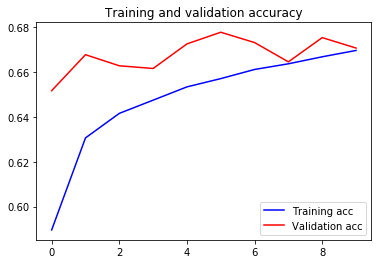

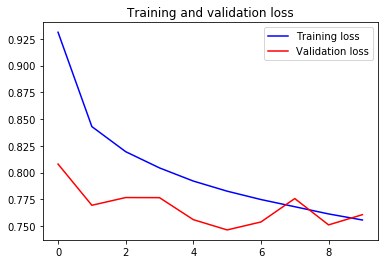

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [26]:
model.save("hatn_yelp2_modregex")
w2v_model.save("w2v2_modregex")
pickle.dump(tokenizer, open("tokenizer2_modregex", "wb"), protocol=0)

2020-04-29 07:53:26,057 : INFO : saving Word2Vec object under w2v2_modregex, separately None
2020-04-29 07:53:26,060 : INFO : storing np array 'vectors' to w2v2_modregex.wv.vectors.npy
2020-04-29 07:53:26,482 : INFO : not storing attribute vectors_norm
2020-04-29 07:53:26,483 : INFO : storing np array 'syn1neg' to w2v2_modregex.trainables.syn1neg.npy
2020-04-29 07:53:26,972 : INFO : not storing attribute cum_table
2020-04-29 07:53:29,033 : INFO : saved w2v2_modregex
